In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
main_path = "/kaggle/input"

paths = []
labels = []

for dirname, _, filenames in os.walk(main_path):
  for filename in filenames:
    paths.append(os.path.join(dirname, filename))
    label = filename.split('_')[-1]
    label = label.split(".")[0]
    labels.append(label.lower())

print("Dataset is loaded.")

Dataset is loaded.


In [3]:
# Creating Dataframe
data_df = pd.DataFrame()
data_df['speech_paths'] = paths
data_df['labels'] = labels
data_df['labels'] = data_df['labels'].astype('category')
data_df.head()

,speech_paths,labels
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [4]:
len(paths)

5600

In [5]:
data_df['labels'].value_counts()

labels
angry      800
disgust    800
fear       800
happy      800
neutral    800
ps         800
sad        800
Name: count, dtype: int64

In [6]:
def waveplotting(data, sr, emotion):
  plt.figure(figsize=(10, 4))
  librosa.display.waveshow(data, sr=sr)
  plt.title(emotion, size=10)
  plt.show()

def spectrogram(data, sr, emotion):
  plt.figure(figsize=(10, 4))
  D = librosa.amplitude_to_db(abs(librosa.stft(data)))
  librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
  plt.colorbar(format='%+2.0f dB')
  plt.title(emotion, size=10)
  plt.show()

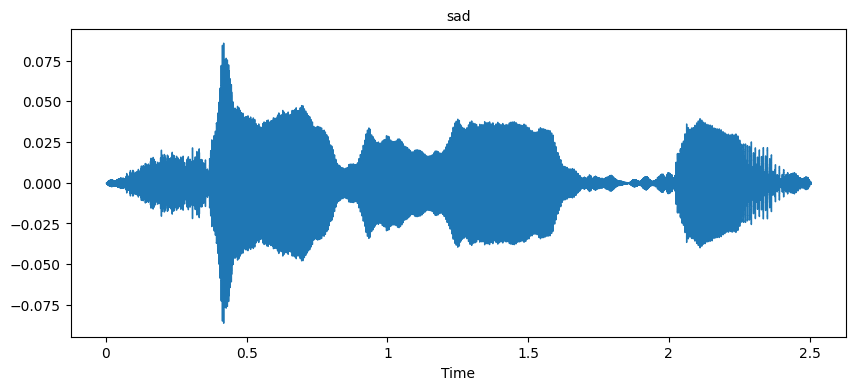

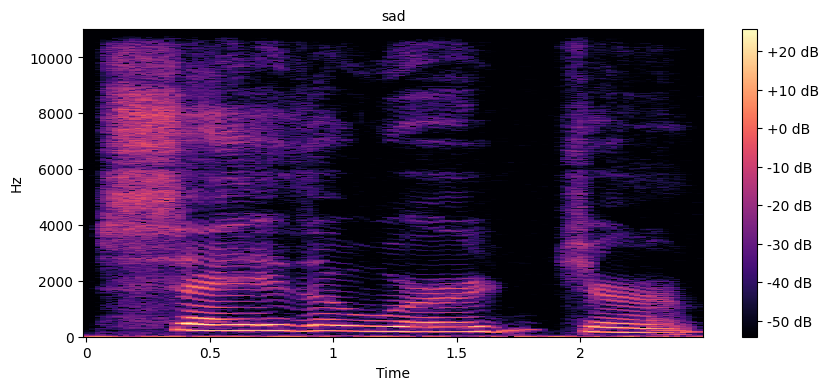

In [7]:
emotion = 'sad'
path = data_df['speech_paths'][data_df['labels'] == emotion].values[0]
data, sr = librosa.load(path)
waveplotting(data, sr, emotion)
spectrogram(data, sr, emotion)
Audio(path)

In [8]:
def extract_mfcc(filename):
  data, sr = librosa.load(filename, duration=3, offset=0.5)
  mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
  return mfccs

extract_mfcc(path)

array([-5.45900574e+02,  1.03277054e+02,  2.88646736e+01,  1.26910019e+01,
        2.59459095e+01,  1.70372028e+01, -6.10911322e+00, -1.67007999e+01,
       -1.80666714e+01,  2.63802266e+00, -1.55368509e+01, -6.14144564e+00,
       -5.36702573e-01,  9.02290583e-01, -4.23823690e+00, -3.39824772e+00,
       -7.06916630e-01, -3.37897003e-01,  2.28359699e+00, -4.91555262e+00,
        5.09795380e+00, -5.08386707e+00, -4.98782825e+00, -3.42583871e+00,
       -7.07974291e+00,  2.15348339e+00, -5.73159504e+00,  1.41807342e+00,
       -4.32420760e-01,  3.34419012e-01,  1.54264271e+00,  1.11076431e+01,
        7.21183681e+00,  1.09250851e+01,  1.28362045e+01,  1.02581587e+01,
        5.36081123e+00,  1.26567183e+01,  9.96775627e+00,  1.58071947e+01],
      dtype=float32)

In [9]:
X_mfcc = data_df['speech_paths'].apply(lambda x: extract_mfcc(x))
x_mfcc = np.array([x for x in X_mfcc])
x_mfcc.shape

(5600, 40)

In [10]:
# For LSTM model, expanding dimentions
x = np.expand_dims(x_mfcc, axis=2)
x.shape

(5600, 40, 1)

In [11]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(data_df['labels']).reshape(-1,1)).toarray()
y.shape

(5600, 7)

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(123, return_sequences=False, input_shape=(40, 1)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 123)               61500     
                                                                 
 dense (Dense)               (None, 64)                7936      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 71747 (280.26 KB)
Trainable params: 71747 

In [13]:
model.fit(x, y, 
          epochs=100, 
          batch_size=512, 
          validation_split=0.2, 
          shuffle = True)

Epoch 1/100
9/9 [==============================] - 7s 79ms/step - loss: 1.7995 - accuracy: 0.3089 - val_loss: 1.9513 - val_accuracy: 0.2152
Epoch 2/100
9/9 [==============================] - 0s 17ms/step - loss: 1.4899 - accuracy: 0.5009 - val_loss: 1.9715 - val_accuracy: 0.1125
Epoch 3/100
9/9 [==============================] - 0s 15ms/step - loss: 1.1858 - accuracy: 0.6433 - val_loss: 1.8034 - val_accuracy: 0.1429
Epoch 4/100
9/9 [==============================] - 0s 14ms/step - loss: 0.8526 - accuracy: 0.7147 - val_loss: 1.3887 - val_accuracy: 0.2670
Epoch 5/100
9/9 [==============================] - 0s 14ms/step - loss: 0.6395 - accuracy: 0.7685 - val_loss: 1.1402 - val_accuracy: 0.4437
Epoch 6/100
9/9 [==============================] - 0s 14ms/step - loss: 0.4682 - accuracy: 0.8299 - val_loss: 0.7393 - val_accuracy: 0.6920
Epoch 7/100
9/9 [==============================] - 0s 13ms/step - loss: 0.3717 - accuracy: 0.8728 - val_loss: 0.5858 - val_accuracy: 0.7527
Epoch 8/100
9/9 [===